In [33]:
# import modules
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
import seaborn as sns
import os
import anndata
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

scvi.settings.seed = 0

Global seed set to 0


In [34]:
# specify working directory
os.chdir('/Volumes/Passport/CSDB/brain_scRNAseq/')

In [10]:
# load in the metadata
meta = pd.read_table('all_internship/data/processed/author_processed/metadata/meta_Aging_mouse_brain_portal_data.txt', dtype = str)
meta

,NAME,cell_type,cell_type_by_age,cell_class,cell_class_by_age,all_cells_by_age,nGene,nUMI
0,TYPE,group,group,group,group,group,numeric,numeric
1,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,1546,3546
2,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,734,1589
3,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,456,1129
4,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,1236,2697
...,...,...,...,...,...,...,...,...
37065,Aging_mouse_brain_portal_data_43_GCACATATCCGTAGTA,MNC,MNC_21-22mo,Immune_cells,Immune_cells_21-22mo,21-22mo,1065,2706
37066,Aging_mouse_brain_portal_data_44_AGCTCTCCAATGTAAG,MNC,MNC_21-22mo,Immune_cells,Immune_cells_21-22mo,21-22mo,534,945
37067,Aging_mouse_brain_portal_data_44_CATCGAACAAACGCGA,MNC,MNC_21-22mo,Immune_cells,Immune_cells_21-22mo,21-22mo,572,963
37068,Aging_mouse_brain_portal_data_44_GGGATGATCTCCTATA,MNC,MNC_21-22mo,Immune_cells,Immune_cells_21-22mo,21-22mo,606,1228


In [11]:
# subset metadata to cell id and age
names = meta[['NAME', 'all_cells_by_age']]
names = names[1:]
names

,NAME,all_cells_by_age
1,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,2-3mo
2,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,2-3mo
3,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,2-3mo
4,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,2-3mo
5,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,2-3mo
...,...,...
37065,Aging_mouse_brain_portal_data_43_GCACATATCCGTAGTA,21-22mo
37066,Aging_mouse_brain_portal_data_44_AGCTCTCCAATGTAAG,21-22mo
37067,Aging_mouse_brain_portal_data_44_CATCGAACAAACGCGA,21-22mo
37068,Aging_mouse_brain_portal_data_44_GGGATGATCTCCTATA,21-22mo


In [12]:
# add column 'condition' to indicate whether samples originate from old or young mice and subset dataframe
names['condition'] = 'old'
names.loc[names['all_cells_by_age'].str.startswith('2-3'), 'condition'] = 'young'
names = names[['NAME', 'condition']]
names

,NAME,condition
1,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,young
2,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,young
3,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,young
4,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,young
5,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,young
...,...,...
37065,Aging_mouse_brain_portal_data_43_GCACATATCCGTAGTA,old
37066,Aging_mouse_brain_portal_data_44_AGCTCTCCAATGTAAG,old
37067,Aging_mouse_brain_portal_data_44_CATCGAACAAACGCGA,old
37068,Aging_mouse_brain_portal_data_44_GGGATGATCTCCTATA,old


In [13]:
# obtain barcodes in list and add '.1'
bc_list = []
for name in names['NAME']:
    bc = name.split('_')
    bc = bc[-1]
    bc = bc + '.1'
    bc_list.append(bc)
bc_list

['AAACCTGAGGCCCTTG.1',
 'AAACGGGAGAGACGAA.1',
 'AAAGTAGCAACGATCT.1',
 'AACCGCGCAACAACCT.1',
 'AACTCCCAGTACGTAA.1',
 'AACTGGTAGAAGGTTT.1',
 'AAGACCTTCCGCTGTT.1',
 'ACACCAAAGGGTCTCC.1',
 'ACACCCTCAATAACGA.1',
 'ACATCAGCAGATCGGA.1',
 'ACGAGCCCATTCCTGC.1',
 'ACGAGGATCGAGAGCA.1',
 'ACTATCTGTGTGAATA.1',
 'AGATCTGTCAACGGGA.1',
 'AGCCTAACAATAAGCA.1',
 'AGCGTCGGTACAGCAG.1',
 'AGCTTGACAAGCGAGT.1',
 'AGGCCACCACGTCAGC.1',
 'AGGCCGTGTCTCTTTA.1',
 'AGGGATGGTTGCGTTA.1',
 'AGGTCATGTGTTGGGA.1',
 'AGTGAGGAGTGTACTC.1',
 'AGTGAGGTCAGTCCCT.1',
 'ATGCGATGTCTAGCGC.1',
 'ATTGGTGCATCGATGT.1',
 'ATTTCTGTCCCATTAT.1',
 'CACAAACCATGGTCAT.1',
 'CACACAAAGACTTGAA.1',
 'CACAGGCAGGAGTACC.1',
 'CAGAGAGAGACAATAC.1',
 'CAGCCGACATCCGGGT.1',
 'CAGCCGATCAAGATCC.1',
 'CAGCGACAGAACTGTA.1',
 'CAGCTAACAAGAAGAG.1',
 'CAGCTGGTCTTTACGT.1',
 'CAGTAACGTCGGCTCA.1',
 'CATCCACCACATGTGT.1',
 'CATTCGCAGAGTCGGT.1',
 'CCACCTATCGGTTAAC.1',
 'CCGGTAGAGGATGGTC.1',
 'CCGGTAGAGTTGAGAT.1',
 'CCTAAAGGTATCAGTC.1',
 'CCTACCAGTTCGGCAC.1',
 'CCTAGCTAG

In [14]:
# add column to dataframe with condition followed by the barcode
names['barcode'] = names['condition'] + '_' + bc_list
names

,NAME,condition,barcode
1,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,young,young_AAACCTGAGGCCCTTG.1
2,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,young,young_AAACGGGAGAGACGAA.1
3,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,young,young_AAAGTAGCAACGATCT.1
4,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,young,young_AACCGCGCAACAACCT.1
5,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,young,young_AACTCCCAGTACGTAA.1
...,...,...,...
37065,Aging_mouse_brain_portal_data_43_GCACATATCCGTAGTA,old,old_GCACATATCCGTAGTA.1
37066,Aging_mouse_brain_portal_data_44_AGCTCTCCAATGTAAG,old,old_AGCTCTCCAATGTAAG.1
37067,Aging_mouse_brain_portal_data_44_CATCGAACAAACGCGA,old,old_CATCGAACAAACGCGA.1
37068,Aging_mouse_brain_portal_data_44_GGGATGATCTCCTATA,old,old_GGGATGATCTCCTATA.1


In [15]:
# extract barcodes
bc = names['barcode']
bc

1        young_AAACCTGAGGCCCTTG.1
2        young_AAACGGGAGAGACGAA.1
3        young_AAAGTAGCAACGATCT.1
4        young_AACCGCGCAACAACCT.1
5        young_AACTCCCAGTACGTAA.1
                   ...           
37065      old_GCACATATCCGTAGTA.1
37066      old_AGCTCTCCAATGTAAG.1
37067      old_CATCGAACAAACGCGA.1
37068      old_GGGATGATCTCCTATA.1
37069      old_TGAAAGACAGACAAGC.1
Name: barcode, Length: 37069, dtype: object

In [ ]:
# load in the TE raw data
adata_TE = sc.read_h5ad('all_internship/data/processed/TE_concat.h5ad')

In [17]:
# load in the gene raw data
adata_gene = sc.read_h5ad('all_internship/data/processed/gene_concat.h5ad')

/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/anndata-0.9.1-py3.10.egg/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
adata_gene.obs

,Sample
AAACCTGAGCTCCTTC.1,OX1X
AAACCTGAGTAGCGGT.1,OX1X
AAACCTGAGTTTCCTT.1,OX1X
AAACCTGCACCCATGG.1,OX1X
AAACCTGCAGTCGTGC.1,OX1X
...,...
TTTGTCATCGGACAAG.1,YX8L
TTTGTCATCGGATGGA.1,YX8L
TTTGTCATCGGCATCG.1,YX8L
TTTGTCATCTGCAAGT.1,YX8L


In [ ]:
adata_TE.obs['Sample'] = adata_gene.obs['Sample']
adata_TE.obs

In [19]:
# add condition column and add condition to the row names
adata_gene.obs['condition'] = 'young'
adata_gene.obs.loc[adata_gene.obs['Sample'].str.startswith('O'), 'condition'] = 'old'
adata_gene.obs.index = adata_gene.obs['condition'] + '_' + adata_gene.obs.index
adata_gene.obs

,Sample,condition
old_AAACCTGAGCTCCTTC.1,OX1X,old
old_AAACCTGAGTAGCGGT.1,OX1X,old
old_AAACCTGAGTTTCCTT.1,OX1X,old
old_AAACCTGCACCCATGG.1,OX1X,old
old_AAACCTGCAGTCGTGC.1,OX1X,old
...,...,...
young_TTTGTCATCGGACAAG.1,YX8L,young
young_TTTGTCATCGGATGGA.1,YX8L,young
young_TTTGTCATCGGCATCG.1,YX8L,young
young_TTTGTCATCTGCAAGT.1,YX8L,young


In [ ]:
# do the same thing for TE data
adata_TE.obs['condition'] = 'young'
adata_TE.obs.loc[adata_TE.obs['Sample'].str.startswith('O'), 'condition'] = 'old'
adata_TE.obs.index = adata_TE.obs['condition'] + '_' + adata_TE.obs.index
adata_TE.obs

In [20]:
# add column filtered that indicates whether a barcode is present in the processed barcodes
# and filter on this
adata_gene.obs['filtered'] = adata_gene.obs.index.isin(bc)
adata_gene = adata_gene[adata_gene.obs.filtered]
adata_gene.obs

,Sample,condition,filtered
old_AAACCTGGTTCTCATT.1,OX1X,old,True
old_AAACCTGTCGGTTCGG.1,OX1X,old,True
old_AAACGGGAGCGATGAC.1,OX1X,old,True
old_AAACGGGTCAAGGCTT.1,OX1X,old,True
old_AAACGGGTCCGTAGTA.1,OX1X,old,True
...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True
young_TTTGTCAGTAAGGATT.1,YX8L,young,True
young_TTTGTCATCAGATAAG.1,YX8L,young,True
young_TTTGTCATCCAAACTG.1,YX8L,young,True


In [21]:
# annotate mito genes with a True or False
adata_gene.var['mt'] = adata_gene.var.index.str.startswith('mt')
adata_gene.var

/var/folders/cw/zsvp54ms4m51744999xglgm80000gn/T/ipykernel_15986/3375691524.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_gene.var['mt'] = adata_gene.var.index.str.startswith('mt')
/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/anndata-0.9.1-py3.10.egg/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/anndata-0.9.1-py3.10.egg/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,mt
0610007P14Rik,False
0610009B22Rik,False
0610009L18Rik,False
0610009O20Rik,False
0610010F05Rik,False
...,...
mt-Nd3,True
mt-Nd4,True
mt-Nd4l,True
mt-Nd5,True


In [22]:
# calculate QC metrics
sc.pp.calculate_qc_metrics(adata_gene, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)
adata_gene.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
0610007P14Rik,False,12323,0.428582,68.691565,16869.0
0610009B22Rik,False,6966,0.209045,82.301829,8228.0
0610009L18Rik,False,2994,0.086255,92.393293,3395.0
0610009O20Rik,False,3926,0.107292,90.025407,4223.0
0610010F05Rik,False,1456,0.039710,96.300813,1563.0
...,...,...,...,...,...
mt-Nd3,True,27661,1.741997,29.723069,68565.0
mt-Nd4,True,39220,17.486103,0.355691,688253.0
mt-Nd4l,True,14275,0.535976,63.732215,21096.0
mt-Nd5,True,25870,1.512678,34.273374,59539.0


In [23]:
# inspect
adata_gene.obs

,Sample,condition,filtered,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
old_AAACCTGGTTCTCATT.1,OX1X,old,True,1569,3784.0,194.0,5.126850
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,1120,3280.0,98.0,2.987805
old_AAACGGGAGCGATGAC.1,OX1X,old,True,2015,5115.0,219.0,4.281525
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,1375,2711.0,399.0,14.717815
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,1665,3738.0,203.0,5.430711
...,...,...,...,...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True,1987,4290.0,439.0,10.233101
young_TTTGTCAGTAAGGATT.1,YX8L,young,True,2724,8442.0,502.0,5.946458
young_TTTGTCATCAGATAAG.1,YX8L,young,True,1253,2526.0,204.0,8.076009
young_TTTGTCATCCAAACTG.1,YX8L,young,True,1805,4251.0,264.0,6.210303


In [24]:
# filter cells based on counts and features
sc.pp.filter_cells(adata_gene, min_counts = 200)
sc.pp.filter_cells(adata_gene, max_counts = 30000)
sc.pp.filter_cells(adata_gene, min_genes = 250)
sc.pp.filter_cells(adata_gene, max_genes = 6000)
# filter out cells with more than 20% counts for mitochondrial genes
adata_gene = adata_gene[adata_gene.obs.pct_counts_mt < 30]
adata_gene

/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/anndata-0.9.1-py3.10.egg/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/anndata-0.9.1-py3.10.egg/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 37581 × 15149
    obs: 'Sample', 'condition', 'filtered', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [28]:
# make row names unique and write to file
adata_gene.obs_names_make_unique()
adata_gene.write_h5ad('all_internship/data/processed/raw_filtered_genes.h5ad')

In [32]:
file = open('all_internship/data/processed/samples.txt', 'w')
for item in adata_gene.obs['Sample']:
    file.write(str(item) + '\n')
file.close()

/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/anndata-0.9.1-py3.10.egg/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


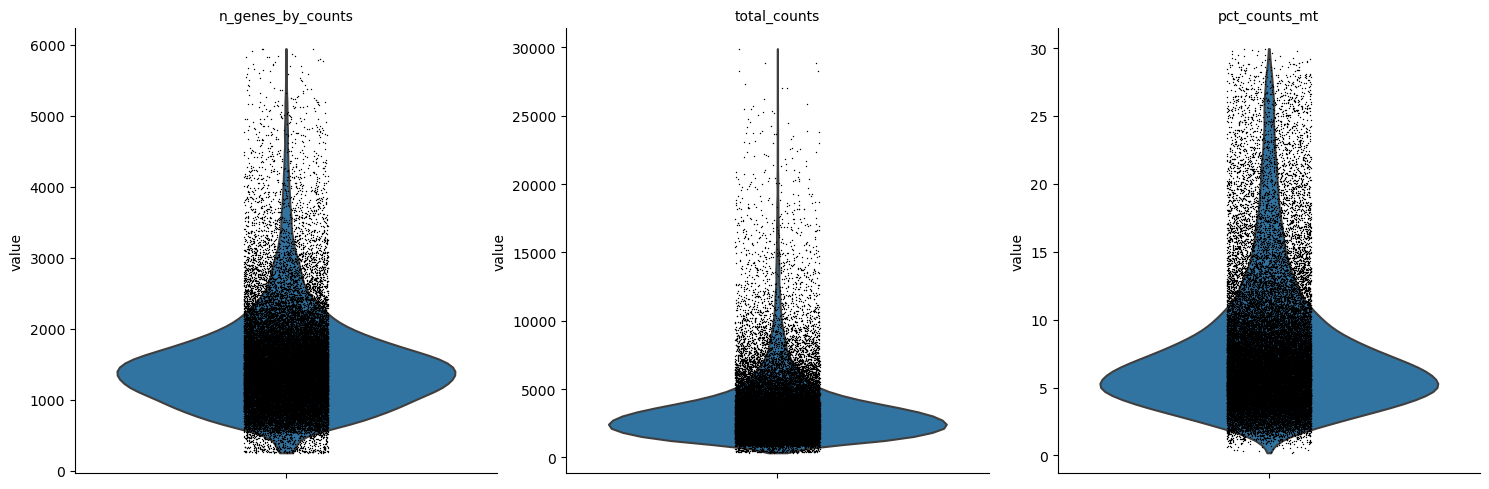

In [163]:
# plot QC metrics
sc.pl.violin(adata_gene, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel = True)

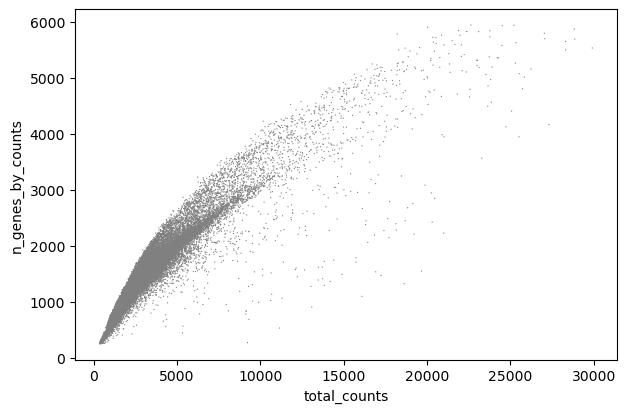

In [164]:
sc.pl.scatter(adata_gene, 'total_counts', 'n_genes_by_counts')

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

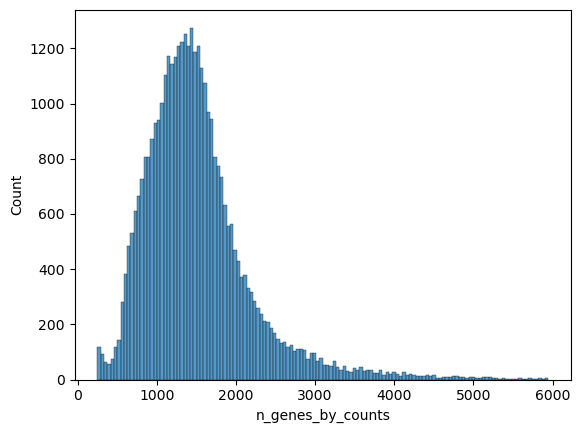

In [166]:
sns.histplot(adata_gene.obs["n_genes_by_counts"])

<Axes: xlabel='total_counts', ylabel='Count'>

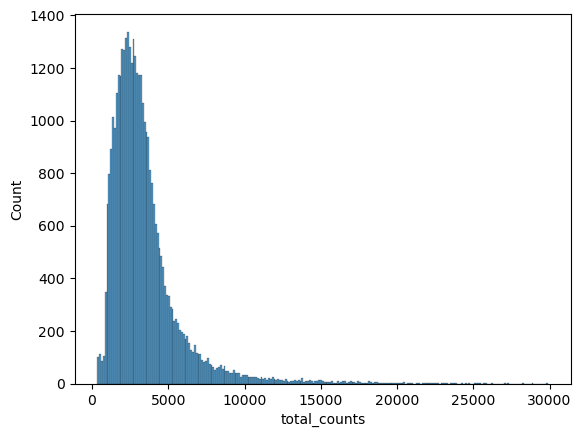

In [167]:
sns.histplot(adata_gene.obs['total_counts'])

In [168]:
# also filter the TE data based on the barcodes
adata_TE.obs['filtered'] = adata_TE.obs.index.isin(adata_gene.obs.index)
adata_TE = adata_TE[adata_TE.obs.filtered]
adata_TE.obs

,Sample,condition,filtered
old_AAACCTGGTTCTCATT.1,OX1X,old,True
old_AAACCTGTCGGTTCGG.1,OX1X,old,True
old_AAACGGGAGCGATGAC.1,OX1X,old,True
old_AAACGGGTCAAGGCTT.1,OX1X,old,True
old_AAACGGGTCCGTAGTA.1,OX1X,old,True
...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True
young_TTTGTCAGTAAGGATT.1,YX8L,young,True
young_TTTGTCATCAGATAAG.1,YX8L,young,True
young_TTTGTCATCCAAACTG.1,YX8L,young,True


In [169]:
# merge TE data and gene data together
merged_adata = anndata.concat([adata_gene, adata_TE], join = 'inner', axis = 1)
merged_adata

AnnData object with n_obs × n_vars = 37581 × 15872

In [170]:
# add metadata
merged_adata.obs = adata_gene.obs
merged_adata.obs

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
old_AAACCTGGTTCTCATT.1,OX1X,old,True,3784.0,1569,1569,3784.0,194.0,5.126850
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,3280.0,1120,1120,3280.0,98.0,2.987805
old_AAACGGGAGCGATGAC.1,OX1X,old,True,5115.0,2015,2015,5115.0,219.0,4.281525
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,2711.0,1375,1375,2711.0,399.0,14.717815
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,3738.0,1665,1665,3738.0,203.0,5.430711
...,...,...,...,...,...,...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True,4290.0,1987,1987,4290.0,439.0,10.233101
young_TTTGTCAGTAAGGATT.1,YX8L,young,True,8442.0,2724,2724,8442.0,502.0,5.946458
young_TTTGTCATCAGATAAG.1,YX8L,young,True,2526.0,1253,1253,2526.0,204.0,8.076009
young_TTTGTCATCCAAACTG.1,YX8L,young,True,4251.0,1805,1805,4251.0,264.0,6.210303


In [ ]:
# write to the filtered and merged object to a file
merged_adata.write('all_internship/data/processed/raw_merged_barcode_filtered.h5ad')